<h1>Load data</h1>

In [2]:
# -- Import --
import pandas as pd
from get_data import get_historical_from_db
import ta
import matplotlib.pyplot as plt
import numpy as np

# - - Load data from database --
df = get_historical_from_db("Binance","BTC/USDT","1h")

print("Data loaded 100%")


Data loaded 100%


<h1>Define indicators</h1>

In [4]:
# -- Drop all columns we do not need --
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

# -- Exponential Moving Average --
df['EMA1']= ta.trend.ema_indicator(close=df['close'], window=7)
df['EMA2']= ta.trend.ema_indicator(close=df['close'], window=30)
df['EMA3']= ta.trend.ema_indicator(close=df['close'], window=50)
df['EMA4']= ta.trend.ema_indicator(close=df['close'], window=100)
df['EMA5']= ta.trend.ema_indicator(close=df['close'], window=121)
df['EMA6']= ta.trend.ema_indicator(close=df['close'], window=200)

# -- Stochasitc RSI --
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)

print("Indicators loaded 100%")

# -- Uncomment the line below if you want to check your dataset with indicators --
#df

Indicators loaded 100%


/tmp/ipykernel_53173/2834628129.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)


<h1>RUN the BackTest</h1>

In [19]:
dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
# dfTest = df['2021-03-01':'2021-09-01']

# -- Definition of dt, that will be the dataset to do your trades analyses --
dt = None
dt = pd.DataFrame(columns=['date', 'position', 'reason',
                           'price', 'frais', 'wallet', 'drawBack'])

# -- You can change variables below --
leverage = 1
wallet = 1000
makerFee = 0.0002
takerFee = 0.0005

# -- Do not touch these values --
initalWallet = wallet
lastAth = wallet
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
orderInProgress = ''
longIniPrice = 0
shortIniPrice = 0
longLiquidationPrice = 500000
shortLiquidationPrice = 0

# -- Condition to open Market LONG --
def openLongCondition(row, previousRow):
    if (row['EMA1'] > row['EMA2'] 
    and row['EMA2'] > row['EMA3'] 
    and row['EMA3'] > row['EMA4'] 
    and row['EMA4'] > row['EMA5'] 
    and row['EMA5'] > row['EMA6'] 
    and row['STOCH_RSI'] < 0.82):
        return True
    else:
        return False

# -- Condition to close Market LONG --
def closeLongCondition(row, previousRow):
    if row['EMA6'] > row['EMA1']:
        return True
    else:
        return False

# -- Condition to open Market SHORT --
def openShortCondition(row, previousRow):
    if ( row['EMA6'] > row['EMA5'] 
    and row['EMA5'] > row['EMA4'] 
    and row['EMA4'] > row['EMA3'] 
    and row['EMA3'] > row['EMA2'] 
    and row['EMA2'] > row['EMA1'] 
    and row['STOCH_RSI'] > 0.2 ):
        return True
    else:
        return False

# -- Condition to close Market SHORT --
def closeShortCondition(row, previousRow):
    if row['EMA1'] > row['EMA6']:
        return True
    else:
        return False

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():

    # -- If there is an order in progress --
    if orderInProgress != '':
        # -- Check if there is a LONG order in progress --
        if orderInProgress == 'LONG':
            # -- Check Liquidation --
            if row['low'] < longLiquidationPrice:
                print('/!\ YOUR LONG HAVE BEEN LIQUIDATED the',index)
                break
            
            # -- Check If you have to close the LONG --
            if closeLongCondition(row, previousRow) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] - takerFee * row['close']
                pr_change = (closePriceWithFee - longIniPrice) / longIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close LONG at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)


                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet
                
                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "LONG", 'reason': 'Close Long Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)

        # -- Check if there is a SHORT order in progress --
        elif orderInProgress == 'SHORT':
            # -- Check Liquidation --
            if row['high'] > shortLiquidationPrice:
                print('/!\ YOUR SHORT HAVE BEEN LIQUIDATED the',index)
                break

            # -- Check If you have to close the SHORT --
            if closeShortCondition(row, previousRow) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] + takerFee * row['close']
                pr_change = -(closePriceWithFee - shortIniPrice) / shortIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close SHORT at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)

                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet

                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "SHORT", 'reason': 'Close Short Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)

    # -- If there is NO order in progress --
    if orderInProgress == '':
        # -- Check If you have to open a LONG --
        if openLongCondition(row, previousRow) == True:
            orderInProgress = 'LONG'
            closePrice = row['close']
            longIniPrice = row['close'] + takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            longLiquidationPrice = longIniPrice - (wallet/tokenAmount)

            # -- You can uncomment the line below if you want to see logs --
            # print('Open LONG at', closePrice, '$ the', index, '| Liquidation price :', longLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Long", 'reason': 'Open Long Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)
        
        # -- Check If you have to open a SHORT --
        if openShortCondition(row, previousRow) == True:
            orderInProgress = 'SHORT'
            closePrice = row['close']
            shortIniPrice = row['close'] - takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            shortLiquidationPrice = shortIniPrice + (wallet/tokenAmount)
            # -- You can uncomment the line below if you want to see logs --
            # print('Open SHORT', closePrice, '$ the', index, '| Liquidation price :', shortLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Short", 'reason': 'Open Short Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            #dt = dt.append(myrow, ignore_index=True)
            dt = pd.concat([dt,pd.DataFrame(myrow, index=[0])], ignore_index=True)


# -- BackTest Analyses --
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat%'] = dt['wallet'].pct_change()*100

dt['tradeIs'] = ''
dt.loc[dt['resultat%'] > 0, 'tradeIs'] = 'Good'
dt.loc[dt['resultat%'] < 0, 'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPercentage = ((lastClose - iniClose)/iniClose)
holdWallet = holdPercentage * leverage * initalWallet
algoPercentage = ((wallet - initalWallet)/initalWallet)
vsHoldPercentage = ((wallet - holdWallet)/holdWallet) * 100

try:
    tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()
            / dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].count(), 2)
except:
    tradesPerformance = 0
    print("/!\ There is no Good or Bad Trades in your BackTest, maybe a problem...")

try:
    TotalGoodTrades = dt.groupby('tradeIs')['date'].nunique()['Good']
    AveragePercentagePositivTrades = round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(), 2)
    idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
    bestTrade = str(
        round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(), 2))
except:
    TotalGoodTrades = 0
    AveragePercentagePositivTrades = 0
    idbest = ''
    bestTrade = 0
    print("/!\ There is no Good Trades in your BackTest, maybe a problem...")

try:
    TotalBadTrades = dt.groupby('tradeIs')['date'].nunique()['Bad']
    AveragePercentageNegativTrades = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(), 2)
    idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
    worstTrade = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(), 2)
except:
    TotalBadTrades = 0
    AveragePercentageNegativTrades = 0
    idworst = ''
    worstTrade = 0
    print("/!\ There is no Bad Trades in your BackTest, maybe a problem...")

totalTrades = TotalBadTrades + TotalGoodTrades

try:
    TotalLongTrades = dt.groupby('position')['date'].nunique()['LONG']
    AverageLongTrades = round(dt.loc[dt['position'] == 'LONG', 'resultat%'].sum()
                              / dt.loc[dt['position'] == 'LONG', 'resultat%'].count(), 2)
    idBestLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmax()
    bestLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].max(), 2))
    idWorstLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmin()
    worstLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].min(), 2))
except:
    AverageLongTrades = 0
    TotalLongTrades = 0
    bestLongTrade = ''
    idBestLong = ''
    idWorstLong = ''
    worstLongTrade = ''
    print("/!\ There is no LONG Trades in your BackTest, maybe a problem...")

try:
    TotalShortTrades = dt.groupby('position')['date'].nunique()['SHORT']
    AverageShortTrades = round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].sum()
                               / dt.loc[dt['position'] == 'SHORT', 'resultat%'].count(), 2)
    idBestShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmax()
    bestShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].max(), 2))
    idWorstShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmin()
    worstShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].min(), 2))
except:
    AverageShortTrades = 0
    TotalShortTrades = 0
    bestShortTrade = ''
    idBestShort = ''
    idWorstShort = ''
    worstShortTrade = ''
    print("/!\ There is no SHORT Trades in your BackTest, maybe a problem...")

try:
    totalGoodLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Good']
except:
    totalGoodLongTrade = 0
    print("/!\ There is no good LONG Trades in your BackTest, maybe a problem...")

try:
    totalBadLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Bad']
except:
    totalBadLongTrade = 0
    print("/!\ There is no bad LONG Trades in your BackTest, maybe a problem...")

try:
    totalGoodShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Good']
except:
    totalGoodShortTrade = 0
    print("/!\ There is no good SHORT Trades in your BackTest, maybe a problem...")

try:
    totalBadShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Bad']
except:
    totalBadShortTrade = 0
    print("/!\ There is no bad SHORT Trades in your BackTest, maybe a problem...")

TotalTrades = TotalGoodTrades + TotalBadTrades
winRateRatio = (TotalGoodTrades/TotalTrades) * 100

reasons = dt['reason'].unique()

print("BackTest finished, final wallet :",wallet,"$")
dt


BackTest finished, final wallet : 19787.692883078897 $


,date,position,reason,price,frais,wallet,drawBack,resultat%,tradeIs
date,,,,,,,,,
2017-08-25 14:00:00,2017-08-25 14:00:00,Open Long,Open Long Market,4305.00,0.500000,1000,0.000000,NaN,
2017-08-25 14:00:00,2017-08-25 14:00:00,Open Long,Open Long Market,4305.00,0.500000,1000,0.000000,0.00000,
2017-08-25 14:00:00,2017-08-25 14:00:00,Open Long,Open Long Market,4305.00,0.500000,1000,0.000000,0.00000,
2017-08-25 14:00:00,2017-08-25 14:00:00,Open Long,Open Long Market,4305.00,0.500000,1000,0.000000,0.00000,
2017-08-25 14:00:00,2017-08-25 14:00:00,Open Long,Open Long Market,4305.00,0.500000,1000,0.000000,0.00000,
...,...,...,...,...,...,...,...,...,...
2022-11-04 15:00:00,2022-11-04 15:00:00,Open Long,Open Long Market,20838.70,9.992136,19984.272171,-0.510897,0.00000,
2022-11-04 15:00:00,2022-11-04 15:00:00,Open Long,Open Long Market,20838.70,9.992136,19984.272171,-0.510897,0.00000,
2022-11-04 15:00:00,2022-11-04 15:00:00,Open Long,Open Long Market,20838.70,9.992136,19984.272171,-0.510897,0.00000,


<h1>Print Complete BackTest Analyses</h1>

In [16]:
print("Pair Symbol :","BTC/USDT",)
print("Period : [" + str(dfTest.index[0]) + "] -> [" +
      str(dfTest.index[len(dfTest)-1]) + "]")
print("Starting balance :", initalWallet, "$")

print("\n----- General Informations -----")
print("Final balance :", round(wallet, 2), "$")
print("Performance vs US Dollar :", round(algoPercentage*100, 2), "%")
print("Buy and Hold Performence :", round(holdPercentage*100, 2),
      "% | with Leverage :", round(holdPercentage*100, 2)*leverage, "%")
print("Performance vs Buy and Hold :", round(vsHoldPercentage, 2), "%")
print("Best trade : +"+bestTrade, "%, the ", idbest)
print("Worst trade :", worstTrade, "%, the ", idworst)
print("Worst drawBack :", str(100*round(dt['drawBack'].min(), 2)), "%")
print("Total fees : ", round(dt['frais'].sum(), 2), "$")

print("\n----- Trades Informations -----")
print("Total trades on period :",totalTrades)
print("Number of positive trades :", TotalGoodTrades)
print("Number of negative trades : ", TotalBadTrades)
print("Trades win rate ratio :", round(winRateRatio, 2), '%')
print("Average trades performance :",tradesPerformance,"%")
print("Average positive trades :", AveragePercentagePositivTrades, "%")
print("Average negative trades :", AveragePercentageNegativTrades, "%")

print("\n----- LONG Trades Informations -----")
print("Number of LONG trades :",TotalLongTrades)
print("Average LONG trades performance :",AverageLongTrades, "%")
print("Best  LONG trade +"+bestLongTrade, "%, the ", idBestLong)
print("Worst LONG trade", worstLongTrade, "%, the ", idWorstLong)
print("Number of positive LONG trades :",totalGoodLongTrade)
print("Number of negative LONG trades :",totalBadLongTrade)
print("LONG trade win rate ratio :", round(totalGoodLongTrade/TotalLongTrades*100, 2), '%')

print("\n----- SHORT Trades Informations -----")
print("Number of SHORT trades :",TotalShortTrades)
print("Average SHORT trades performance :",AverageShortTrades, "%")
print("Best  SHORT trade +"+bestShortTrade, "%, the ", idBestShort)
print("Worst SHORT trade", worstShortTrade, "%, the ", idWorstShort)
print("Number of positive SHORT trades :",totalGoodShortTrade)
print("Number of negative SHORT trades :",totalBadShortTrade)
print("SHORT trade win rate ratio :", round(totalGoodShortTrade/TotalShortTrades*100, 2), '%')

print("\n----- Trades Reasons -----")
reasons = dt['reason'].unique()
for r in reasons:
    print(r+" number :", dt.groupby('reason')['date'].nunique()[r])

Pair Symbol : BTC/USDT
Period : [2017-08-17 04:00:00] -> [2022-11-07 19:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 19787.69 $
Performance vs US Dollar : 1878.77 %
Buy and Hold Performence : 381.03 % | with Leverage : 381.03 %
Performance vs Buy and Hold : 419.32 %
Best trade : +128.74 %, the  2017-12-19 21:00:00
Worst trade : -12.35 %, the  2019-07-03 03:00:00
Worst drawBack : -59.0 %
Total fees :  4156.38 $

----- Trades Informations -----
Total trades on period : 268
Number of positive trades : 83
Number of negative trades :  185
Trades win rate ratio : 30.97 %
Average trades performance : 1.73 %
Average positive trades : 12.51 %
Average negative trades : -3.11 %

----- LONG Trades Informations -----
Number of LONG trades : 130
Average LONG trades performance : 3.44 %
Best  LONG trade +128.74 %, the  2017-12-19 21:00:00
Worst LONG trade -9.93 %, the  2021-01-15 18:00:00
Number of positive LONG trades : 46
Number of negative LONG trades : 84
LON

<h1>Plot to improve ...</h1>


----- Plot -----


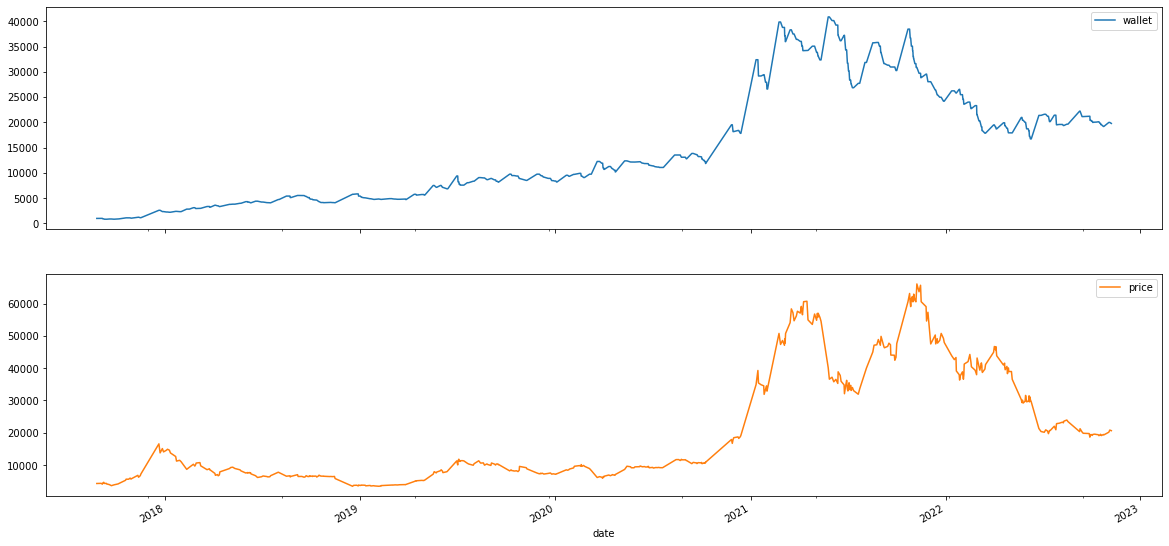

In [10]:
dt[['wallet', 'price']].plot(subplots=True, figsize=(20, 10))
print("\n----- Plot -----")